# Variational optimization of continuous matrix product states
## Supplementary material: comparision with Matrix Product States


## Setup

This notebook is an addendu to the notebook arXiv:2006.01801.ipynb and assumes the same setup. The required packages can be installed by uncommenting the following lines.

In [ ]:
# import Pkg;
# Pkg.activate()
# Pkg.instantiate()
# Pkg.add(url="https://github.com/Jutho/CMPSKit.jl")

Now, we load these packages, though we restrict to only specific methods or types to be loaded from KrylovKit, OptimKit and Plots.

In [2]:
using CMPSKit
using KrylovKit: Arnoldi, GMRES
using OptimKit: GradientDescent, ConjugateGradient, LBFGS
using JLD2
using Plots: plot, plot!
using IJulia
using LinearAlgebra

For comparing with MPS simulations, we also need to install and load the following packages:

In [3]:
# import Pkg
# Pkg.add("TensorKit","MPSKit","MPSKitModels")
using TensorKit
using MPSKit
using MPSKitModels

## Particles in a box in the Tonks-Girardeau limit

### cMPS and its discretisation into an MPS
We first revisit the cMPS simulation of particles in a box in the Tonks-Girardeau limit (large interaction strength), where we only use chemical potential but no inhomogeneous external potential. We first compare our cMPS results with results obtained from regarding it as an MPS according to the well known correspondence. A comparision with a variationally optimized MPS follows below.

We first define the operators in the continuum.

In [4]:
(a, b) = (0., 1.) # box / interval
μ = (4.75*π)^2 # chemical potential
g = 1e6; # interaction strength

# Local densities:
n̂_continuum = ψ̂'*ψ̂; # particle density operator
k̂_continuum = ∂ψ̂'*∂ψ̂; # kinetic energy density operator
û_continuum = (ψ̂')^2*ψ̂^2; # interaction operator

# Hamiltonian
Ĥ₁_continuum = ∫(k̂_continuum - μ * n̂_continuum + g * û_continuum, (a, b));

We now load the variationally obtained cMPS ground state approximation for this Hamiltonian, and recompute its properties.

In [5]:
@load "FiniteCMPS_D=8_mu=223_g=1e6.jld" Ψ

D = 8
ρL_cMPS, ρR_cMPS, = environments!(Ψ; tol = 1e-14)
particle_density_cMPS = expval(n̂_continuum, Ψ, ρL_cMPS, ρR_cMPS)
kinetic_energy_density_cMPS = expval(k̂_continuum, Ψ, ρL_cMPS, ρR_cMPS)
interaction_energy_density_cMPS = expval(g*û_continuum, Ψ, ρL_cMPS, ρR_cMPS);
energy_density_cMPS = kinetic_energy_density_cMPS - μ * particle_density_cMPS + interaction_energy_density_cMPS;
energy_cMPS = integrate(energy_density_cMPS, (a,b))
particle_number_cMPS = integrate(particle_density_cMPS, (a,b))


entanglement_grid = 0:1/3200:1
spectra_cMPS = sort.(real.(eigvals.((ρL_cMPS*ρR_cMPS).(entanglement_grid))), rev=true)
spectra_reorganized_cMPS = [collect(abs(s[i]) for s in spectra_cMPS) for i = 1:D];

(energy_cMPS, particle_number_cMPS)

(-594.4455915858346, 3.9998806469359605)

This cMPS uses a piecewise linear representation of the $Q$ and $R$ matrix on a grid with spacing $\epsilon = 1/32$. We now build a lattice discretisation of this Hamiltonian. Working with the same boundary conditions corresponds to having no particles at the boundaries, which is equivalent to having a state which is non-trivial only at the 31 bulk points at position `x = (1:31)/32`. We furthermore truncate the number of particles on a given site to `mode_cutoff = 5` and use an otherwise naive discretisation of the different continuum operators. The density and interaction potential become onsite operators. The kinetic energy becomes a nearest neighbour operator, which is best associated with the interval between two neighbouring sites, and where we take into account that there is an extra empty site on either boundary.

In [6]:
M = 31 # number of lattice points in the interval (a,b), with coordinates a + (i/M+1)*(b-a) for i = 1:M
ϵ = (b-a)/(M+1) # associated lattice spacing
mode_cutoff = 5 # number of bosonic modes
(c⁺,c⁻) = nonsym_bosonictensors(mode_cutoff)

n̂_lattice = c⁺*c⁻ / ϵ
û_lattice = c⁺*c⁺*c⁻*c⁻ / ϵ^2
i = one(c⁺)
k̂_lattice = (c⁺ ⊗ i - i ⊗ c⁺) * (c⁻ ⊗ i - i ⊗ c⁻) / ϵ^3
k̂_lattice_boundary = c⁺*c⁻ / ϵ^3;

At first, we build an MPS by applying the standard prescription $A^0 = 1 + \epsilon Q$ and $A^k = \frac{(\sqrt{\epsilon} R)^k}{\sqrt{k!}}$ on this grid. We also have to take into account the effect of the cMPS boundary which is specified by the choice of $v_L$ and $v_R$, both of which were chosen as the standard unit vector along the first dimension.

In [31]:
MPSgrid = a .+ ϵ .* (1:M)
Qmats = Ψ.Q.(MPSgrid)
Rmats = Ψ.Rs[1].(MPSgrid)
d = mode_cutoff + 1
Amats = map(Qmats, Rmats) do Q, R
    reshape(vcat(one(Q) + ϵ*Q, (sqrt(ϵ)^k * R^k/sqrt(factorial(k)) for k=1:mode_cutoff)...), (D, d, D))
end
# implement cMPS boundary conditions resulting from `vL` and `vR`
Amats[1] = reshape(Ψ.vL' * reshape(Amats[1], (D, d*D)), (1, d, D))
Amats[M] = reshape(reshape(Amats[M], D*d, D) * Ψ.vR, (D, d, 1))
As = map(Amats) do A
    Dl, d, Dr = size(A)
    TensorMap(A, ℂ^Dl ⊗ ℂ^d, ℂ^Dr)
end
ΨMPS = FiniteMPS(As; normalize = true);

particle_density_MPS = real(expectation_value(ΨMPS, n̂_lattice))
interaction_energy_density_MPS = real(expectation_value(ΨMPS, g*û_lattice))
kinetic_energy_density_MPS = real([expectation_value(ΨMPS, k̂_lattice_boundary, 1);
                                    [expectation_value(ΨMPS, k̂_lattice, i) for i = 1:M-1];
                                    expectation_value(ΨMPS, k̂_lattice_boundary, M)])
MPS_kinetic_grid = a .+ ϵ .* ((1:M+1) .- 0.5)

energy_density_MPS = (kinetic_energy_density_MPS[2:end] + kinetic_energy_density_MPS[1:end-1])/2 - μ * particle_density_MPS + interaction_energy_density_MPS
energy_MPS = ϵ * (sum(kinetic_energy_density_MPS) - μ * sum(particle_density_MPS) + sum(interaction_energy_density_MPS))
particle_number_MPS = ϵ * sum(particle_density_MPS)
(energy_MPS, particle_number_MPS)

(-437.76930601327706, 3.9643935353488047)

That is pretty far off the cMPS result. Let us visualize these results.

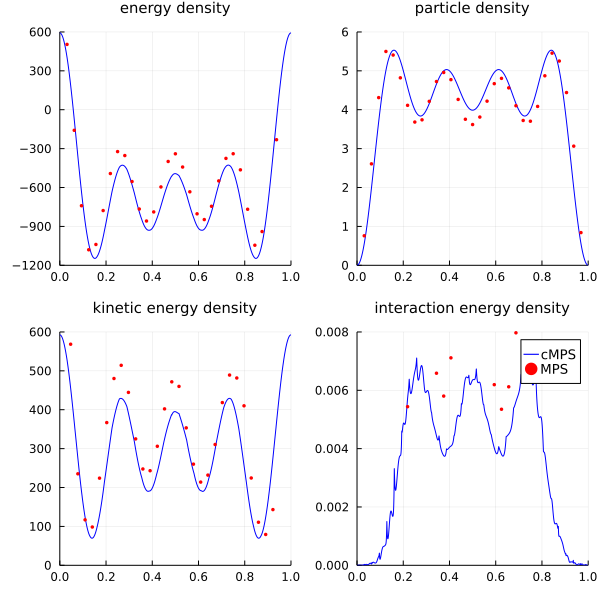

In [32]:
cMPS_plotgrid = 0:1/3200:1
p1 = plot(cMPS_plotgrid, energy_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (-1200, 600), title = "energy density")
plot!(p1, MPSgrid, energy_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "")
p2 = plot(cMPS_plotgrid, particle_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (0,6), title = "particle density")
plot!(p2, MPSgrid, particle_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "")
p3 = plot(cMPS_plotgrid, kinetic_energy_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (0,600), title = "kinetic energy density")
plot!(p3, MPS_kinetic_grid, kinetic_energy_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "")
p4 = plot(cMPS_plotgrid, interaction_energy_density_cMPS.(cMPS_plotgrid), label = "cMPS", linecolor = :blue, xlims = (0,1), ylims = (0, 8e-3), title = "interaction energy density")
plot!(p4, MPSgrid, interaction_energy_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "MPS")
plot(p1, p2, p3, p4, layout = (2,2), titlefontsize = 10, tickfontsize = 8, legendfontsize = 9, size = (600, 600))

The specific grid on which the cMPS matrices were parameterized as piecewise linear functions has no particular relevance to the lattice discretisation. The cMPS is defined everywhere in the continuum. So we can also apply the same construction to extract an MPS on a much finer grid, which should then provide a more accurate approximation to the cMPS.

In [33]:
M′ = 3199 # number of lattice points in the interval (a,b), with coordinates a + (i/M+1)*(b-a) for i = 1:M
ϵ′ = (b-a)/(M′+1) # associated lattice spacing
n̂_lattice′ = c⁺*c⁻ / ϵ′
û_lattice′ = c⁺*c⁺*c⁻*c⁻ / ϵ′^2
k̂_lattice′ = (c⁺ ⊗ i - i ⊗ c⁺) * (c⁻ ⊗ i - i ⊗ c⁻) / ϵ′^3
k̂_lattice_boundary′ = c⁺*c⁻ / ϵ′^3

MPSgrid′ = a .+ ϵ′ .* (1:M′)
Qmats′ = Ψ.Q.(MPSgrid′)
Rmats′ = Ψ.Rs[1].(MPSgrid′)
Amats′ = map(Qmats′, Rmats′) do Q, R
     reshape(vcat(one(Q) + ϵ′*Q, (sqrt(ϵ′)^k * R^k/sqrt(factorial(k)) for k=1:mode_cutoff)...), (D, d, D))
end
# implement cMPS boundary conditions resulting from `vL` and `vR`
Amats′[1] = reshape(Ψ.vL' * reshape(Amats′[1], (D, d*D)), (1, d, D))
Amats′[M′] = reshape(reshape(Amats′[M′], D*d, D) * Ψ.vR, (D, d, 1))
As′ = map(Amats′) do A
    Dl, d, Dr = size(A)
    TensorMap(A, ℂ^Dl ⊗ ℂ^d, ℂ^Dr)
end
ΨMPS′ = FiniteMPS(As′; normalize = true);

particle_density_MPS′ = real(expectation_value(ΨMPS′, n̂_lattice′))
interaction_energy_density_MPS′ = real(expectation_value(ΨMPS′, g*û_lattice′))
kinetic_energy_density_MPS′ = real([expectation_value(ΨMPS′, k̂_lattice_boundary′, 1);
                                    [expectation_value(ΨMPS′, k̂_lattice′, i) for i = 1:M′-1];
                                    expectation_value(ΨMPS′, k̂_lattice_boundary′, M′)]);
MPS_kinetic_grid′ = a .+ ϵ′ .* ((1:M′+1) .- 0.5)

energy_density_MPS′ = (kinetic_energy_density_MPS′[2:end] + kinetic_energy_density_MPS′[1:end-1])/2 - μ * particle_density_MPS′ + interaction_energy_density_MPS′
energy_MPS′ = ϵ′ * (sum(kinetic_energy_density_MPS′) - μ * sum(particle_density_MPS′) + sum(interaction_energy_density_MPS′))
particle_number_MPS′ = ϵ′ * sum(particle_density_MPS′)
(energy_MPS′, particle_number_MPS′)

(-593.8678910723477, 3.999876673368931)

This is starting to approximate the exact cMPS values. Let's again visualize the result.

In [34]:
cMPS_plotgrid = 0:1/3200:1
p1 = plot(cMPS_plotgrid, energy_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (-1200, 600), title = "energy density")
plot!(p1, MPSgrid′, energy_density_MPS′, seriestype = :scatter, markersize = 1, markercolor = :red, markerstrokewidth = 0, label = "")
p2 = plot(cMPS_plotgrid, particle_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (0,6), title = "particle density")
plot!(p2, MPSgrid′, particle_density_MPS′, seriestype = :scatter, markersize = 1, markercolor = :red, markerstrokewidth = 0, label = "")
p3 = plot(cMPS_plotgrid, kinetic_energy_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (0,600), title = "kinetic energy density")
plot!(p3, MPS_kinetic_grid′, kinetic_energy_density_MPS′, seriestype = :scatter, markersize = 1, markercolor = :red, markerstrokewidth = 0, label = "")
p4 = plot(cMPS_plotgrid, interaction_energy_density_cMPS.(cMPS_plotgrid), label = "cMPS", linecolor = :blue, xlims = (0,1), ylims = (0, 8e-3), title = "interaction energy density")
plot!(p4, MPSgrid′, interaction_energy_density_MPS′, seriestype = :scatter, markersize = 1, markercolor = :red, markerstrokewidth = 0, label = "MPS")
plot(p1, p2, p3, p4, layout = (2,2), titlefontsize = 10, tickfontsize = 8, legendfontsize = 9, size = (600, 600))

In this case, the expectation values from the cMPS and its discretisation into a MPS match very well. There are some small discrepencies near the boundaries, which are most notable in the interaction energy. Before discussing these, note that in the middle region the MPS captures the fine and irregular details in the cMPS expectation value of the interaction energy, which occur within a single interval of the piecewise linear model for the cMPS matrices. This illustrates that these features are not inaccuracies in computing the cMPS expectation values, but artefacts of the piecewise linear model for the matrices $Q(x)$ and $R(x)$, in combination with the high power thereof appearing in the interaction energy.

Regarding the boundaries, the discrepancies can be attributed to accumulated differences in the MPS and cMPS environments $\rho_L$ and $\rho_R$. The cMPS environments are determined by a Lindblad equation in terms of the matrices $Q(x)$ and $R(x)$. The equation that determines the MPS environments can be recognized as a first order Euler scheme for integrating this differential equation (it contains higher order terms, but not all the terms necessary to really represent a higher order Euler scheme). We can verify this explicitly by computing the difference between the MPS and cMPS environments, where we associate the MPS environments with a position halfway in between the sites.

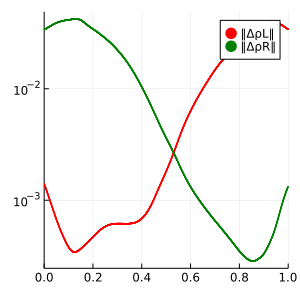

In [36]:
ρLs′ = [ones(Float64, (1,1))]
for i = 1:M′
    @tensor ρL′[-1;-2] := conj(Amats′[i][1,3,-1])*ρLs′[i][1,2]*Amats′[i][2,3,-2]
    push!(ρLs′, ρL′)
end
ρRs′ = [ones(Float64, (1,1))]
for i = M′:-1:1
    @tensor ρR′[-1;-2] := Amats′[i][-1,3,1]*ρRs′[1][1,2]*conj(Amats′[i][-2,3,2])
    pushfirst!(ρRs′, ρR′)
end
ρ′grid = a .+ ϵ′ .* ((2:M′) .- 0.5)
p = plot(ρ′grid, norm.(ρLs′[2:M′] .- ρL_cMPS.(ρ′grid)), label = "‖ΔρL‖", seriestype = :scatter, markersize = 1, markercolor = :red, markerstrokewidth = 0, xlim = (0,1), size = (300, 300), yscale = :log10)
plot!(p, ρ′grid, norm.(ρRs′[2:M′] .- ρR_cMPS.(ρ′grid)), label = "‖ΔρR‖", seriestype = :scatter, markersize = 1, markercolor = :green, markerstrokewidth = 0)

Hence, we observe that $\rho_L$, which is determined from left to right, starts to deviate more strongly near the right boundary, whereas the opposite situation presents itself for $\rho_R$. As both environments appear in the computation of expectation values of local observables, discrepancies can be expected on both sides, and are expected to be most accurate in the middle of the interval.

### Variational cMPS versus variational MPS
We now compare our cMPS results with results from a variationally optimized MPS for the discretized Hamiltonian.

We first compute an MPS on the grid corresponding to that which defines the piecewise linear functions of our cMPS matrices. This gives an idea of how well an MPS with roughly the same number of parameters compares to the cMPS. Strictly speaking, though, the MPS has more parameters, as the different matrices associated with different occupation numbers per site are independent.

We now build the Hamiltonian (as a matrix product operator) and use the MPS obtained from the cMPS as initial guess to start the variational optimization.

In [69]:
Ĥ₁_lattice = let
    data = Array{Any,3}(missing, M, 4, 4);
    data[:,1,1] .= 1.0;
    data[:,end,end] .= 1.0;

    for i in 1:M
        data[i,1,2] = -1/ϵ^2 * c⁺
        data[i,1,3] = -1/ϵ^2 * c⁻
        data[i,2,4] = c⁻
        data[i,3,4] = c⁺
        data[i,1,4] = (-μ + 2/ϵ^2) * (c⁺*c⁻) + (g/ϵ) * (c⁺*c⁺*c⁻*c⁻)
    end

    MPOHamiltonian(data)
end
sum(expectation_value(ΨMPS, Ĥ₁_lattice))

-437.76930601325313

In [71]:
ΨMPS, MPS_environments, = find_groundstate!(ΨMPS, Ĥ₁_lattice, Dmrg(; maxiter = 30))

particle_density_MPS = real(expectation_value(ΨMPS, n̂_lattice))
interaction_energy_density_MPS = real(expectation_value(ΨMPS, g*û_lattice))
kinetic_energy_density_MPS = real([expectation_value(ΨMPS, k̂_lattice_boundary, 1);
                                    [expectation_value(ΨMPS, k̂_lattice, i) for i = 1:M-1];
                                    expectation_value(ΨMPS, k̂_lattice_boundary, M)])
MPS_kinetic_grid = a .+ ϵ .* ((1:M+1) .- 0.5)

energy_density_MPS = (kinetic_energy_density_MPS[2:end] + kinetic_energy_density_MPS[1:end-1])/2 - μ * particle_density_MPS + interaction_energy_density_MPS
energy_MPS = ϵ * (sum(kinetic_energy_density_MPS) - μ * sum(particle_density_MPS) + sum(interaction_energy_density_MPS))
particle_number_MPS = ϵ * sum(particle_density_MPS)
(energy_MPS, particle_number_MPS)

┌ Info: Iteraton 0 error 1.8875106511250264e-7
└ @ MPSKit /Users/jutho/.julia/dev/MPSKit/src/algorithms/groundstate/dmrg.jl:28
┌ Info: Iteraton 1 error 1.8875109267656763e-7
└ @ MPSKit /Users/jutho/.julia/dev/MPSKit/src/algorithms/groundstate/dmrg.jl:28
┌ Info: Iteraton 2 error 1.8875110231900195e-7
└ @ MPSKit /Users/jutho/.julia/dev/MPSKit/src/algorithms/groundstate/dmrg.jl:28
┌ Info: Iteraton 3 error 1.8875111271648484e-7
└ @ MPSKit /Users/jutho/.julia/dev/MPSKit/src/algorithms/groundstate/dmrg.jl:28
┌ Info: Iteraton 4 error 1.887511065947428e-7
└ @ MPSKit /Users/jutho/.julia/dev/MPSKit/src/algorithms/groundstate/dmrg.jl:28
┌ Info: Iteraton 5 error 1.8875111160787243e-7
└ @ MPSKit /Users/jutho/.julia/dev/MPSKit/src/algorithms/groundstate/dmrg.jl:28
┌ Info: Iteraton 6 error 1.8875110845233191e-7
└ @ MPSKit /Users/jutho/.julia/dev/MPSKit/src/algorithms/groundstate/dmrg.jl:28
┌ Info: Iteraton 7 error 1.8875110161594133e-7
└ @ MPSKit /Users/jutho/.julia/dev/MPSKit/src/algorithms/groundst

(-597.352618783794, 3.9999679408852797)

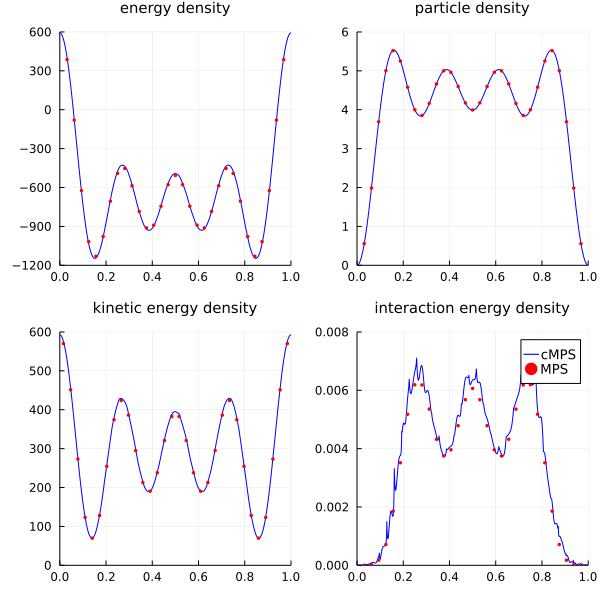

In [72]:
p1 = plot(cMPS_plotgrid, energy_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (-1200, 600), title = "energy density")
plot!(p1, MPSgrid, energy_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "")
p2 = plot(cMPS_plotgrid, particle_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (0,6), title = "particle density")
plot!(p2, MPSgrid, particle_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "")
p3 = plot(cMPS_plotgrid, kinetic_energy_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (0,600), title = "kinetic energy density")
plot!(p3, MPS_kinetic_grid, kinetic_energy_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "")
p4 = plot(cMPS_plotgrid, interaction_energy_density_cMPS.(cMPS_plotgrid), label = "cMPS", linecolor = :blue, xlims = (0,1), ylims = (0, 8e-3), title = "interaction energy density")
plot!(p4, MPSgrid, interaction_energy_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "MPS")
plot(p1, p2, p3, p4, layout = (2,2), titlefontsize = 10, tickfontsize = 8, legendfontsize = 9, size = (600, 600))

The agreement is now very good. Note that the energy of the discretised Hamiltonian is not an upper bound to that of the continuum Hamiltonian: the variational MPS has a lower energy than the continuum energy.

For completeness, we also compare the cMPS to a variational MPS obtained at a finer grid with `M = 200` sites:

In [75]:
@load "FiniteMPS_D=8_mu=223_g=1e6.jld" ΨMPS

M = length(ΨMPS) # number of lattice points in the interval (a,b), with coordinates a + (i/M+1)*(b-a) for i = 1:M
ϵ = (b-a)/(M+1) # associated lattice spacing

n̂_lattice = c⁺*c⁻ / ϵ
û_lattice = c⁺*c⁺*c⁻*c⁻ / ϵ^2
i = one(c⁺)
k̂_lattice = (c⁺ ⊗ i - i ⊗ c⁺) * (c⁻ ⊗ i - i ⊗ c⁻) / ϵ^3
k̂_lattice_boundary = c⁺*c⁻ / ϵ^3;

MPSgrid = a .+ ϵ .* (1:M)
particle_density_MPS = real(expectation_value(ΨMPS, n̂_lattice))
interaction_energy_density_MPS = real(expectation_value(ΨMPS, g*û_lattice))
kinetic_energy_density_MPS = real([expectation_value(ΨMPS, k̂_lattice_boundary, 1);
                                    [expectation_value(ΨMPS, k̂_lattice, i) for i = 1:M-1];
                                    expectation_value(ΨMPS, k̂_lattice_boundary, M)])
MPS_kinetic_grid = a .+ ϵ .* ((1:M+1) .- 0.5)

energy_density_MPS = (kinetic_energy_density_MPS[2:end] + kinetic_energy_density_MPS[1:end-1])/2 - μ * particle_density_MPS + interaction_energy_density_MPS
energy_MPS = ϵ * (sum(kinetic_energy_density_MPS) - μ * sum(particle_density_MPS) + sum(interaction_energy_density_MPS))
particle_number_MPS = ϵ * sum(particle_density_MPS)
(energy_MPS, particle_number_MPS)

(-594.7183329478507, 3.9999999999999596)

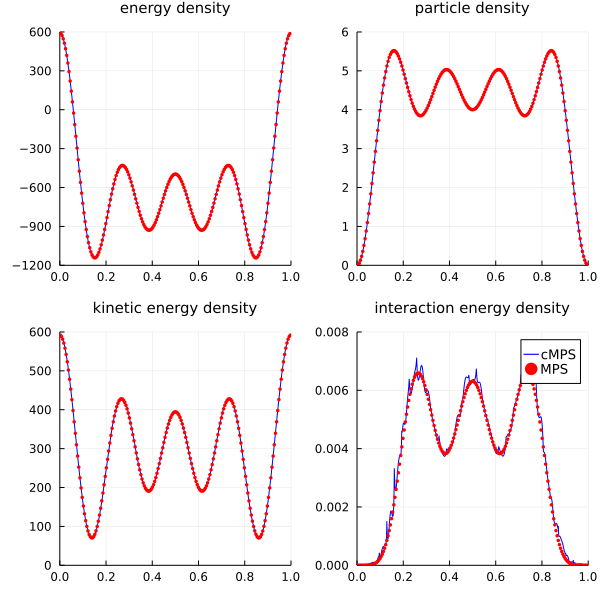

In [76]:
p1 = plot(cMPS_plotgrid, energy_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (-1200, 600), title = "energy density")
plot!(p1, MPSgrid, energy_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "")
p2 = plot(cMPS_plotgrid, particle_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (0,6), title = "particle density")
plot!(p2, MPSgrid, particle_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "")
p3 = plot(cMPS_plotgrid, kinetic_energy_density_cMPS.(cMPS_plotgrid), label = "", linecolor = :blue, xlims = (0,1), ylims = (0,600), title = "kinetic energy density")
plot!(p3, MPS_kinetic_grid, kinetic_energy_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "")
p4 = plot(cMPS_plotgrid, interaction_energy_density_cMPS.(cMPS_plotgrid), label = "cMPS", linecolor = :blue, xlims = (0,1), ylims = (0, 8e-3), title = "interaction energy density")
plot!(p4, MPSgrid, interaction_energy_density_MPS, seriestype = :scatter, markersize = 2, markercolor = :red, markerstrokewidth = 0, label = "MPS")
plot(p1, p2, p3, p4, layout = (2,2), titlefontsize = 10, tickfontsize = 8, legendfontsize = 9, size = (600, 600))

Hence, the cMPS with much less parameters can easily reproduce the smooth behaviour of energy and particle densities. Only the interaction energy (which is very small and thus contributes little to the total energy) is less smooth for the cMPS, as discussed above.

## Inhomogeneous potential

We now study problems with an inhomogeneous potential $V(x)$. We hereto define a new Hamiltonian $\hat{H}_2$.

In [ ]:
Ĥ₂(; g, μ, v) = Ĥ₁(;g = g, μ = μ) + ∫(v * ψ̂'*ψ̂, (a,b));

We consider a box with an external potential $V(x) \sim\sin(15\pi x)$, with $\mu = 1749$ and $g = 35$.

In [ ]:
μ = 1749.
g = 35.
V(x) = sin(15*π*x)

We will find an optimal finite cMPS representation of the ground state with bond dimension $D=32$. To get a better initial state, we can first solve the homogeneous problem in the thermodynamic limit using infinite cMPS. We do not converge this to very high accuracy, as its only purpose is to build a slightly improved initial finite cMPS.

In [ ]:
D = 32 # bond dimension
T = Float64 # scalar type
Q₀ = randn(T, (D,D))
R₀ = randn(T, (D,D))
Ψ∞ = InfiniteCMPS(Constant(Q₀), Constant(R₀))
Ĥ∞(; g, μ) = ∫(k̂ - μ * n̂ + g * û, (-Inf,+Inf));

In [ ]:
alg = LBFGS(80; verbosity = 2, maxiter = 2000)
Ψ∞, ρL∞, ρR∞, E∞, e∞, normgrad, numfg, history = groundstate(Ĥ∞(g = g, μ = μ), Ψ∞; optalg = alg)

We now use the $Q$ and $R$ matrix of this infinite cMPS to initialize the finite cMPS. Note that all matrices are wrapped in the type `Constant`, which indicates that they are constant functions, and not, say, periodic functions represented as a `FourierSeries`. Also note that the resulting cMPS is in the left gauge. We transform it to a symmetric gauge where $\rho_L = \rho_R$ and are a diagonal matrix $\Lambda$.

In [ ]:
Q∞, (R∞,) = Ψ∞
Q₀ = Q∞[]
R₀ = R∞[]
@show norm(Q₀ + Q₀' + R₀'*R₀) # test ρ_L = I
Σ, U = eigen(Hermitian(ρR∞[]); sortby=x->(-abs(x)))
Λ = Diagonal(sqrt.(Σ))
Q₀ = sqrt(Λ)\U'*Q₀*U*sqrt(Λ)
R₀ = sqrt(Λ)\U'*R₀*U*sqrt(Λ)
@show norm(Q₀*Λ + Λ*Q₀' + R₀*Λ*R₀') # test ρ_R = Λ
@show norm(Λ*Q₀ + Q₀'*Λ + R₀'*Λ*R₀); # test ρ_L = Λ

We also measure the particle density in this state:

In [ ]:
n∞ = expval(n̂, Ψ∞);
@show n∞[];

We now build a finite cMPS on a grid with $\Delta x = 10^{-2}$ by using $Q(x)=Q_0$ and $R(x)=R_0 f(x)$ with $f(a)=f(b) = 0$ and $f(x) \approx 1$ in the middle. Given that there will be $O(30)$ particles in the box of length $b-a = 1$, we should probably reach the bulk behaviour in a distance of about $\delta \approx 1/30$.

In [ ]:
D = 32 # bond dimension
T = Float64 # scalar type
grid = 0:1/100:1
Q = PiecewiseLinear(grid, [Q₀ for x in grid])
δ = 1/30
R = PiecewiseLinear(grid, [R₀*ifelse(x<δ, x/δ, ifelse(1-x < δ, (1-x)/δ, 1.)) for x in grid])
vL = setindex!(zeros(T, D), 1, 1)
vR = setindex!(zeros(T, D), 1, 1)
Ψ₀ = FiniteCMPS(Q, R, vL, vR);

In order to use the inhomogeneous potential $V(x)$ in our groundstate algorithm, we also have to represent it as a `Piecewise` of `TaylorSeries` elements. 

In [ ]:
v = CMPSKit.Piecewise(grid, [fit(V, TaylorSeries, (grid[i],grid[i+1])) for i in 1:length(grid)-1])
# let's confirm this works
p = plot(plotgrid, v.(plotgrid), label = "v (Piecewise)", linecolor = :blue, xlim = (0,1), ylim = (-1,1));
plot!(p, plotgrid, V.(plotgrid), label = "V (original)", linecolor = :red, linewidth = 2, linestyle = :dot)
plot(p, tickfontsize = 8, legendfontsize = 9, size = (300, 300))

We also adapt the callback function to plot the results during the optimisation.

In [ ]:
function plotresults₂(; μ, v, g, plotgrid = 0:1/500:1, frequency = 1)
    function callback(numiter, E, normgrad, Ψ, ρL, ρR, e)
        if mod(numiter, frequency) == 0
            IJulia.clear_output(true)
            kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
            interaction_energy_density = expval(g * û, Ψ, ρL, ρR);# plot densities
            particle_density = expval(n̂, Ψ, ρL, ρR)
            N = ∫(particle_density, (a, b))
            potential_energy_density = expval((v - μ*one(v)) * n̂, Ψ, ρL, ρR)
            total_energy_density = e;
            p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), xlims = (0,1), ylims = (-20e4, 10e4), ticks = ([-20e4, -15e4,-10e4,-5e4,0,5e4,10e4],["-20×10⁴","-15×10⁴","-10×10⁴","-5×10⁴","0","+5×10⁴","+10×10⁴"]), label="kinetic")
            plot!(p1, plotgrid, potential_energy_density.(plotgrid), label="potential")
            plot!(p1, plotgrid, interaction_energy_density.(plotgrid), label="interaction")
            plot!(p1, plotgrid, total_energy_density.(plotgrid), label="total")
            plot!(p1, title = "iteration $numiter\n energy densities (E = $E)")
            p2 = plot(plotgrid, particle_density.(plotgrid), label="", xlims = (0,1), ylims=(0,60), title="gradient norm = $normgrad \n particle density (N = $N)")
            display(plot(p1, p2, layout = (1,2), titlefontsize = 9, tickfontsize = 8, legendfontsize = 9, size = (800, 400)))
        end
    end
    return callback
end

We now compute the finite cMPS ground state approximation for three different values of $V(x)$ with increasing modulation strength, namely $V_1(x) = \frac{\mu}{4} \sin(15 \pi x)$, $V_2(x) = \frac{\mu}{2} \sin(15 \pi x)$ and $V_3(x) = \mu \sin(15 \pi x)$. For $V_1(x)$, we use $\Psi_0$ as an initial guess. For the next values of $V(x)$, we can use the previous result. In a few 100 iterations, the result are already qualitatively good.

In [ ]:
v₁ = μ/4*v
v₂ = μ/2*v
v₃ = μ*v;

In [ ]:
alg = LBFGS(50; maxiter = 100)
Ψ₁, ρL₁, ρR₁, E₁, e₁ =
    groundstate(Ĥ₂(μ = μ, v = v₁, g = g), Ψ₀; optalg = alg, callback = plotresults₂(μ = μ, g = g, v = v₁));

In [ ]:
alg = LBFGS(50; maxiter = 50)
Ψ₂, ρL₂, ρR₂, E₂, e₂ =
    groundstate(Ĥ₂(μ = μ, v = v₂, g = g), Ψ₁; optalg = alg, callback = plotresults₂(μ = μ, g = g, v = v₂));

In [ ]:
alg = LBFGS(50; maxiter = 50)
Ψ₃, ρL₃, ρR₃, E₃, e₃ =
    groundstate(Ĥ₂(μ = μ, v = v₃, g = g), Ψ₂; optalg = alg, callback = plotresults₂(μ = μ, g = g, v = v₃));

To proceed, we can load better converged results from disk, though this is not strictly necessary. Note that they are a bit smoother and have a slightly lower energy, but more significantly that they have a better converged total particle number and thus less particle number fluctuations.

In [ ]:
@load "FiniteCMPS_D=32_mu=1749_g=35_v=437sin.jld" Ψ
ρL, ρR, = environments!(Ψ)
total_energy_density = expval(density(Ĥ₂(μ = μ, v = v₁, g = g)), Ψ, ρL, ρR)
E = ∫(total_energy_density, (a, b))
kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
interaction_energy_density = expval(g * û, Ψ, ρL, ρR);# plot densities
particle_density = expval(n̂, Ψ, ρL, ρR)
N = ∫(particle_density, (a, b))
potential_energy_density = expval((v₁ - μ*one(v₁)) * n̂, Ψ, ρL, ρR)
p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), xlims = (0,1), ylims = (-20e4, 10e4), ticks = ([-20e4, -15e4,-10e4,-5e4,0,5e4,10e4],["-20×10⁴","-15×10⁴","-10×10⁴","-5×10⁴","0","+5×10⁴","+10×10⁴"]), label="kinetic")
plot!(p1, plotgrid, potential_energy_density.(plotgrid), label="potential")
plot!(p1, plotgrid, interaction_energy_density.(plotgrid), label="interaction")
plot!(p1, plotgrid, total_energy_density.(plotgrid), label="total")
plot!(p1, title = "energy densities\n (E = $E)")
p2 = plot(plotgrid, particle_density.(plotgrid), label="", xlims = (0,1), ylims = (0,60), title="particle density\n (N = $N)")
display(plot(p1, p2, layout = (1,2), titlefontsize = 10, legendfontsize = 9, tickfontsize = 8, size = (600, 300)))
Ψ₁, ρL₁, ρR₁, E₁, e₁, n₁ = Ψ, ρL, ρR, E, total_energy_density, particle_density;

In [ ]:
@load "FiniteCMPS_D=32_mu=1749_g=35_v=874sin.jld" Ψ
ρL, ρR, = environments!(Ψ)
total_energy_density = expval(density(Ĥ₂(μ = μ, v = v₂, g = g)), Ψ, ρL, ρR)
E = ∫(total_energy_density, (a, b))
kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
interaction_energy_density = expval(g * û, Ψ, ρL, ρR);# plot densities
particle_density = expval(n̂, Ψ, ρL, ρR)
N = ∫(particle_density, (a, b))
potential_energy_density = expval((v₂ - μ*one(v₂)) * n̂, Ψ, ρL, ρR)
p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), xlims = (0,1), ylims = (-20e4, 10e4), ticks = ([-20e4, -15e4,-10e4,-5e4,0,5e4,10e4],["-20×10⁴","-15×10⁴","-10×10⁴","-5×10⁴","0","+5×10⁴","+10×10⁴"]), label="kinetic")
plot!(p1, plotgrid, potential_energy_density.(plotgrid), label="potential")
plot!(p1, plotgrid, interaction_energy_density.(plotgrid), label="interaction")
plot!(p1, plotgrid, total_energy_density.(plotgrid), label="total")
plot!(p1, title = "energy densities\n (E = $E)")
p2 = plot(plotgrid, particle_density.(plotgrid), label="", xlims = (0,1), ylims = (0,60), title="particle density\n (N = $N)")
display(plot(p1, p2, layout = (1,2), titlefontsize = 10, legendfontsize = 9, tickfontsize = 8, size = (600, 300)))
Ψ₂, ρL₂, ρR₂, E₂, e₂, n₂ = Ψ, ρL, ρR, E, total_energy_density, particle_density;

In [ ]:
@load "FiniteCMPS_D=32_mu=1749_g=35_v=1749sin.jld" Ψ
ρL, ρR, = environments!(Ψ)
total_energy_density = expval(density(Ĥ₂(μ = μ, v = v₃, g = g)), Ψ, ρL, ρR)
E = ∫(total_energy_density, (a, b))
kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
interaction_energy_density = expval(g * û, Ψ, ρL, ρR);# plot densities
particle_density = expval(n̂, Ψ, ρL, ρR)
N = ∫(particle_density, (a, b))
potential_energy_density = expval((v₃ - μ*one(v₃)) * n̂, Ψ, ρL, ρR)
p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), xlims = (0,1), ylims = (-20e4, 10e4), ticks = ([-20e4, -15e4,-10e4,-5e4,0,5e4,10e4],["-20×10⁴","-15×10⁴","-10×10⁴","-5×10⁴","0","+5×10⁴","+10×10⁴"]), label="kinetic")
plot!(p1, plotgrid, potential_energy_density.(plotgrid), label="potential")
plot!(p1, plotgrid, interaction_energy_density.(plotgrid), label="interaction")
plot!(p1, plotgrid, total_energy_density.(plotgrid), label="total")
plot!(p1, title = "energy densities\n (E = $E)")
p2 = plot(plotgrid, particle_density.(plotgrid), label="", xlims = (0,1), ylims = (0,60), title="particle density\n (N = $N)")
fig2 = plot(p1, p2, layout = (1,2), titlefontsize = 10, legendfontsize = 9, tickfontsize = 8, size = (600, 300))
display(fig2)
Ψ₃, ρL₃, ρR₃, E₃, e₃, n₃ = Ψ, ρL, ρR, E, total_energy_density, particle_density;

## Bethe ansatz and local density approximation

We now want to compare these density profiles to those predicted by applying the local density approximation to the Bethe ansatz results in the thermodynamic limit. Hereto, we have to solve the Bethe equations, which are given in terms of a parameter $q$ by an integral equation

$$\rho(k) = \frac{1}{2\pi} - \frac{1}{2\pi}\int_{-q}^{+q} K(g, k, k^\prime) \rho(k^\prime) d k^\prime$$

with the kernel $K$ given by

$$K(g, k, k^\prime) = \frac{-2g}{g^2 + (k-k^\prime)^2}$$

(see e.g. Eq. 2.42 in https://arxiv.org/pdf/1609.02100.pdf).

We can then compute the corresponding particle density

$$ n = \int_{-q}^{+q} \rho(k) d k$$

and energy density

$$ e = \int_{-q}^{+q} k^2 \rho(k) d k $$

and eliminate $q$ to find $e$ in terms of $n$. Note that the Bethe energy $e(q)$ only contains the contribution of the kinetic and interaction energy, and not that of the potential energy. In the ensemble of fixed particle number, we can compute the chemical potential as

$$ \mu = \frac{d e}{d n} = (\frac{d e}{d q}) / (\frac{d n}{d q}).$$

Alternatively, for a given $\mu$, we can directly find $q$ which minimizes $e(q) - \mu n(q)$ which results in the same equation.

To compute the derivatives $\frac{d n}{d q}$ and $\frac{d e}{d q}$, we compute $\frac{ d \rho}{d q}(k)$, which is similarly defined by the integral equation

$$\frac{ d \rho}{d q}(k) = K(g, k, q)  \frac{\rho(q)}{2\pi} + K(g, k, -q) \frac{\rho(-q)}{2\pi} +  \frac{1}{2\pi}\int_{-q}^{+q} K(g, k, k^\prime) \frac{ d \rho}{d q}(k^\prime) d k^\prime.$$

We solve these integral equations by discretising the $k$-interval $(-q, q)$ in $N$ segments, using the most naive form of numerical integration (midpoint rule). 

In [ ]:
kernel(g, k, k′) = -2*g/(g^2+(k-k′)^2)
function bethe(g, q; N = 100)
    if iszero(q)
        return 0., 0., 1/pi, 0.
    end
    dk = 2*q/N
    kgrid = range(-q, stop = q, length = N+1)
    dkgrid = dk*vcat([0.5], ones(Float64, N-1), [0.5])
    M = I + (kernel.(g, kgrid, kgrid') .* dkgrid')/(2π)
    ρ = M\(ones(Float64, N+1)/(2π))
    dρ = M\((-1/(2π)) .* (kernel.(g, kgrid, q) .* ρ[N] .+ kernel.(g, kgrid, -q) .* ρ[1]))
    e = sum(kgrid.^2 .* ρ .* dkgrid)
    de = q^2*ρ[end] + q^2*ρ[1] + sum(kgrid.^2 .* dρ .* dkgrid)
    n = sum(ρ .* dkgrid)
    dn = ρ[end] + ρ[1] + sum(dρ .* dkgrid)
    return n, e, dn, de
end

We now compute the result of the `bethe` function for a range of `q` values, sufficiently big such that the resulting chemical potentials range from $0$ to $2\mu$ with $\mu = 1749$, which is what we will need to be able to apply the local density approximation to our local values of the chemical potential $\mu - V(x)$.

In [ ]:
qgrid = range(0, stop = 75, length = 1000)
n_bethe = zeros(Float64, length(qgrid))
e_bethe = zeros(Float64, length(qgrid))
dn_bethe = zeros(Float64, length(qgrid))
de_bethe = zeros(Float64, length(qgrid))
for (i, q) in enumerate(qgrid)
    n_bethe[i], e_bethe[i], dn_bethe[i], de_bethe[i] = bethe(g, q)
end
μ_bethe = de_bethe ./ dn_bethe;
@show maximum(μ_bethe) > 2*μ;

In [ ]:
p1 = plot(qgrid, n_bethe, linecolor = :blue, title = "n(q)", xlim = (0,80), ylim = (0, 70), labels = "")
p2 = plot(qgrid, e_bethe, linecolor = :blue, title = "e(q)", xlim = (0,80), ylim = (0,12.5e4), yticks = ([0,25,50,75,100,125]*1e3, ["0","25×10³","50×10³","75×10³","100×10³","125×10³"]), labels = "")
p3 = plot(qgrid, μ_bethe, linecolor = :blue, title = "μ(q)", xlim = (0,80), ylim = (0,4000), labels = "")
plot(p1, p2, p3, layout = (1,3), size = (900, 300), titlefontsize = 10, tickfontsize = 8)

As in particular $\mu$ is a monotonically increasing array, we can easily eliminate $q$ and obtain the particle and energy density as a function of the chemical potential by using linear interpolation. We define

In [ ]:
particle_density_bethe = PiecewiseLinear(μ_bethe, n_bethe)
energy_density_bethe = PiecewiseLinear(μ_bethe, e_bethe .- μ_bethe .* n_bethe)
μ_range = range(0, stop = 2*μ, length = 1000)
p1 = plot(μ_range, particle_density_bethe.(μ_range), linecolor = :blue, title = "n(μ)", xlim = (0, 4000), ylim = (0, 70), labels = "")
p2 = plot(μ_range, energy_density_bethe.(μ_range), linecolor = :blue, title = "e(μ)", xlim = (0, 4000), ylim = (-125e3,0), yticks = ([0,-25,-50,-75,-100,-125]*1e3, ["0","-25×10³","-50×10³","-75×10³","-100×10³","-125×10³"]), labels = "")
plot(p1, p2, titlefontsize = 10, tickfontsize = 8, layout = (1, 2), size = (600, 300))

We can compare the Bethe ansatz result with our infinite cMPS result:

In [ ]:
@show particle_density_bethe(μ), n∞[]
@show energy_density_bethe(μ), e∞[];

The infinite cMPS result is (sometimes, depending on the random initial guess) a bit lower in energy, which seems to be in violation of the variational principle. This is caused, not by an error in the linear interpolation (as $e(\mu)$ is concave), but because of the approximation of the integral in the Bethe equations. Indeed, we can find the optimal $q$ for given $\mu$ by minimizing $e(q) - \mu n(q)$ as outlined above, and now use a higher value of $N$, the number of points in the midpoint approximation to the integral. Practically, we find $q$ by finding the zero of $\frac{d e}{d q} - \mu \frac{d n}{d q}$ using a simple secant method.

In [ ]:
q_guess = PiecewiseLinear(μ_bethe, collect(qgrid))(μ)
q_a = q_guess - 0.1
n_a, e_a, dn_a, de_a = bethe(g, q_a; N = 2000)
q_b = q_guess + 0.1
n_b, e_b, dn_b, de_b = bethe(g, q_b; N = 2000)
@show grad_a = de_a - μ * dn_a
@show grad_b = de_b - μ * dn_b
i = 1
q_c = (q_a * grad_b - q_b * grad_a) / (grad_b - grad_a)
n_c, e_c, dn_c, de_c = bethe(g, q_c; N = 2000)
grad_c = de_c - μ * dn_c
println("Secant iteration $i: de_c - μ * dn_c = $grad_c")

In [ ]:
while abs(grad_c) > 1e-12
    i += 1
    if grad_c < 0
        q_a = q_c
        grad_a = grad_c
    else
        q_b = q_c
        grad_b = grad_c
    end
    q_c = (q_a * grad_b - q_b * grad_a) / (grad_b - grad_a)
    n_c, e_c, dn_c, de_c = bethe(g, q_c; N= 2000)
    grad_c = de_c - μ * dn_c
    println("Secant iteration $i: de_c - μ * dn_c = $grad_c")
end

In [ ]:
@show e_c - μ*n_c, e∞[];
@show n_c, n∞[];

Problem solved: in fact, the infinite cMPS result was still a bit too high, which can be a result of finite bond dimension $D$, but also because it was not fully converged at the current bond dimension either.

We now compare the inhomogeneous results obtained with the finite cMPS to a local density approximation applied to the Bethe ansatz, i.e. we assume that the local energy density $e(x)$ and $n(x)$ is just that of the thermodynamic limit Bethe ansatz result corresponding to a chemical potential $\mu(x) = \mu - V(x)$.

In [ ]:
μ₁(x) = μ - v₁(x)
μ₂(x) = μ - v₂(x)
μ₃(x) = max(μ - v₃(x), 0.) # can become slightly negative due to floating point errors
p1 = plot(plotgrid, n₁.(plotgrid), linecolor = :blue, label = "", xlims = (0,1), ylims = (0,70), xticks = (0:0.2:1, [""]), yticks = 0:10:70, yguide="particle density", title = "μ₁(x) = μ - (μ/4) sin(15 π x)", titlefontsize = 10)
plot!(p1, plotgrid, particle_density_bethe.(μ₁.(plotgrid)), label = "", linecolor = :red, linewidth = 2, linestyle = :dot)
p2 = plot(plotgrid, n₂.(plotgrid), linecolor = :blue, labels = "", xlims = (0,1), ylims = (0,70), xticks = (0:0.2:1, [""]), yticks = (0:10:70, [""]), title = "μ₂(x) = μ - (μ/2) sin(15 π x)", titlefontsize = 10)
plot!(p2, plotgrid, particle_density_bethe.(μ₂.(plotgrid)), label = "", linecolor = :red, linewidth = 2, linestyle = :dot)
p3 = plot(plotgrid, n₃.(plotgrid), linecolor = :blue, labels = "", xlims = (0,1), ylims = (0,70), xticks = (0:0.2:1, [""]), yticks = (0:10:70, [""]), title = "μ₃(x) = μ - μ sin(15 π x)", titlefontsize = 10)
plot!(p3, plotgrid, particle_density_bethe.(μ₃.(plotgrid)), label = "", linecolor = :red, linewidth = 2, linestyle = :dot)
p4 = plot(plotgrid, e₁.(plotgrid), linecolor = :blue, labels = "", xlims = (0,1), ylims = (-15e4,+5e4), xticks = 0:0.2:1, yticks = ((-15:5:5)*1e4, ["-15×10⁴","-10×10⁴","-5×10⁴","0","+5×10⁴"]), yguide="energy density")
plot!(p4, plotgrid, energy_density_bethe.(μ₁.(plotgrid)), label = "", linecolor = :red, linewidth = 2, linestyle = :dot)
p5 = plot(plotgrid, e₂.(plotgrid), linecolor = :blue, labels = "", xlims = (0,1), ylims = (-15e4,+5e4), xticks = 0:0.2:1, yticks = ((-15:5:5)*1e4, [""]))
plot!(p5, plotgrid, energy_density_bethe.(μ₂.(plotgrid)), label = "", linecolor = :red, linewidth = 2, linestyle = :dot)
p6 = plot(plotgrid, e₃.(plotgrid), linecolor = :blue, label = "cMPS", xlims = (0,1), ylims = (-15e4,+5e4), xticks = 0:0.2:1, yticks = ((-15:5:5)*1e4, [""]))
plot!(p6, plotgrid, energy_density_bethe.(μ₃.(plotgrid)), label = "LDA/Bethe", linecolor = :red, linewidth = 2, linestyle = :dot)
fig3 = plot(p1, p2, p3, p4, p5, p6, layout = (2, 3), titlefontsize = 10, labelfontsize = 10, tickfontsize = 8, legendfontsize = 9, size = (900, 600))

We see that the local density approximation (LDA) is quite good away from the boundaries for the energy density in the case of $V_1(x)$ and $V_2(x)$ which are sufficiently smaller than the chemical potential (though the particle density prediction has already significant errors). In the case $V_3(x)$, both energy and particle density cannot be captured by the LDA.

## Casimir energy

As a final example, we calculate the boundary or Casimir energy of such an interacting Bose gas. We therefore study the system in a box of length $L = 1$ with $V(x) = 0$, $μ = 10000$ and $g = 1000$ using a cMPS with $D = 64$ and a grid of 300 intervals (with an inhomogeneous distribution of the grid points such that there are more points in the bulk of the system). We first find the corresponding infinite cMPS describing this system in the thermodynamic limit. Again we can load a preconverged result from disk.

In [ ]:
g = 1000.
μ = 10000.
D = 64 # bond dimension
T = Float64 # scalar type
optimisation = false
if optimisation
    Q₀ = randn(T, (D,D))
    R₀ = randn(T, (D,D))
    Ψ∞ = InfiniteCMPS(Constant(Q₀), Constant(R₀))
    alg = LBFGS(80; verbosity = 2, maxiter = 2000)
    Ψ∞, ρL∞, ρR∞, E∞, e∞, normgrad, numfg, history = groundstate(Ĥ∞(g = g, μ = μ), Ψ∞; optalg = alg)
else
    @load "InfiniteCMPS_D=64_mu=10000_g=1000.jld" Ψ∞
    ρL∞, ρR∞ = environments!(Ψ∞)
    e∞ = expval(density(Ĥ∞(g = g, μ = μ)), Ψ∞, ρL∞, ρR∞)
    E∞ = e∞[]
end
n∞ = expval(n̂, Ψ∞, ρL∞, ρR∞)
@show e∞[], n∞[];

Let's compare this to the Bethe ansatz result. We again run our secant algorithm, now for $g = 1000$ and using a very wide initial interval.

In [ ]:
q_a = 0
n_a, e_a, dn_a, de_a = bethe(g, q_a; N = 2000)
q_b = 200
n_b, e_b, dn_b, de_b = bethe(g, q_b; N = 2000)
@show grad_a = de_a - μ * dn_a
@show grad_b = de_b - μ * dn_b
i = 1
q_c = (q_a * grad_b - q_b * grad_a) / (grad_b - grad_a)
n_c, e_c, dn_c, de_c = bethe(g, q_c; N = 2000)
grad_c = de_c - μ * dn_c
println("Secant iteration $i: de_c - μ * dn_c = $grad_c")
while abs(grad_c) > 1e-9
    i += 1
    if grad_c < 0
        q_a = q_c
        grad_a = grad_c
    else
        q_b = q_c
        grad_b = grad_c
    end
    q_c = (q_a * grad_b - q_b * grad_a) / (grad_b - grad_a)
    n_c, e_c, dn_c, de_c = bethe(g, q_c; N= 2000)
    grad_c = de_c - μ * dn_c
    println("Secant iteration $i: de_c - μ * dn_c = $grad_c")
end
n_bethe = n_c;
e_bethe = e_c;

In [ ]:
@show e_bethe - μ*n_bethe, e∞[];
@show n_bethe, n∞[];
@show γ = g/n_bethe;

Note that a generic cMPS, in particular an infinite cMPS, is similar to a coherent state in that it discribes a superposition over different particle numbers. It does thus not have a fixed paricle number, i.e. it breaks the $\mathsf{U}_1$ particle number symmetry, and has a nonzero expectation value for the order parameter $\langle \hat{\psi}\rangle$ corresponding to Bose-Einstein condensation. This is different for the exact solution, which has no total particle number flucutations even in the thermodynamic limit, and thus a zero value for the order parameter, i.e. there is no Bose-Einstein condensation in one spatiatl dimension. We can measure the order parameter for the optimal cMPS and find that it is quite large (though it should be measured relative to the square root of the density to have an intrinsic value); breaking the global $\mathsf{U}_1$ symmetry helps significantly to reduce the entanglement but has little effect on the local properties of the state:

In [ ]:
@show bec_order∞ = expval(ψ̂, Ψ∞, ρL∞, ρR∞)[];
@show relative_bec_order∞ = bec_order∞ / sqrt(n∞[]);

Now we compute the corresponding finite cMPS approximation for the Bose gas in the box. We can again use the infinite result to construct a slightly better initial guess. Nonetheless, we recommend using the converged result from disk, as this optimisation requires a large number of iterations and can thus take several days or weeks.

In [ ]:
optimisation = false
if optimisation
    Q∞, (R∞,) = Ψ∞
    Q₀ = Q∞[]
    R₀ = R∞[]
    Σ, U = eigen(Hermitian(ρR∞[]); sortby=x->(-abs(x)))
    Λ = Diagonal(sqrt.(Σ))
    Q₀ = sqrt(Λ)\U'*Q₀*U*sqrt(Λ)
    R₀ = sqrt(Λ)\U'*R₀*U*sqrt(Λ)
    N = 300
    krange = range(0.,stop = 1.,length = N+1);
    grid = (1 .- cos.(krange .* pi)) ./ 2
    Q = PiecewiseLinear(grid, [Q₀ for x in grid])
    δ = 1/30
    R = PiecewiseLinear(grid, [R₀*ifelse(x<δ, x/δ, ifelse(1-x < δ, (1-x)/δ, 1.)) for x in grid])
    vL = setindex!(zeros(T, D), 1, 1)
    vR = setindex!(zeros(T, D), 1, 1)
    Ψ₀ = FiniteCMPS(Q, R, vL, vR);    
    alg = LBFGS(50; maxiter = 10^6)    
    Ψ, ρL, ρR, E, e, normgrad, numfg, history =
        groundstate(Ĥ₁(μ=μ, g=g), Ψ₀; optalg = alg, callback = plotresults₁(μ=μ, g=g; frequency = 1));
else
    @load "FiniteCMPS_D=64_mu=10000_g=1000.jld" Ψ
    ρL, ρR = environments!(Ψ)
    E = expval(Ĥ₁(μ=μ, g=g), Ψ, ρL, ρR)
end;

As before, we plot the particle density and different contributions to the energy density.

In [ ]:
energy_density = expval(CMPSKit.density(Ĥ₁(μ=μ, g=g)), Ψ, ρL, ρR)
particle_density = expval(n̂, Ψ, ρL, ρR)
kinetic_energy_density = expval(k̂, Ψ, ρL, ρR)
interaction_energy_density = expval(g*û, Ψ, ρL, ρR)
plotgrid = 0:1/3200:1
p1 = plot(plotgrid, energy_density.(plotgrid), linecolor = :blue, xlim = (0,1), ylim = (-4e5, 4e5), yticks = ((-4:2:4) .* 1e5, ["-4×10⁵", "-2×10⁵", "0","+2×10⁵","+4×10⁵"]), label = "", title = "energy density")
p2 = plot(plotgrid, particle_density.(plotgrid), linecolor = :blue, xlim = (0,1), ylim = (0, 50), label = "", title="particle density")
p3 = plot(plotgrid, kinetic_energy_density.(plotgrid), linecolor = :blue, xlim = (0,1), ylim = (0, 25e4), yticks = ((0:5:25) .* 1e4, ["0", "5×10⁴", "10×10⁴","15×10⁴","20×10⁴","25×10⁴"]), label = "", title = "kinetic energy density")
p4 = plot(plotgrid, interaction_energy_density.(plotgrid), linecolor = :blue, xlim = (0,1), ylim = (0, 2e4), yticks = ((0:5:20) .* 1e3, ["0", "5×10³", "10×10³","15×10³","20×10³"]), label="", title="interaction energy density")
fig4 = plot(p1, p2, p3, p4, layout = (2,2), titlefontsize = 10, tickfontsize = 8, size = (600, 600))

We observe strong Friedel oscillations resulting from the hard boundaries, which exist throughout the whole system. Note that the same pattern also manifests itself in the entanglement structure of the ground state, by considering a left-right bipartition of the system for various positions $0\leq x \leq 1$ of the cut.

In [ ]:
entanglement_grid = 0:1/3200:1
spectra = sort.(real.(eigvals.((ρL*ρR).(entanglement_grid))), rev=true)
spectra_reorganized = [collect(abs(s[i]) for s in spectra) for i = 1:D]
entropy(spectrum) = sum(-abs(p)*log(abs(p)) for p in spectrum)
p1 = plot(entanglement_grid, spectra_reorganized, linecolor = :blue, xlim = (0,1), yscale = :log10, label="", ylim = (1e-12,1), title = "entanglement spectra")
p2 = plot(entanglement_grid, entropy.(spectra),  linecolor = :blue, xlim = (0,1), ylim = (0, 1.25), label="", title = "entanglement entropy")
fig5 = plot(p1, p2, layout = (1,2), titlefontsize = 10, tickfontsize = 8, size = (600, 300))

The location of the peaks, in particular in the particle density, can be interpreted as the location of the particles, which have strong tendency to be fixed on a lattice. In the thermodynamic limit, such a lattice cannot exist in one dimension without explicit breaking of translation symmetry by an external potential, but in a finite box the boundaries provide the required symmetry breaking. At the same time, compared to the infinite cMPS, the finite cMPS does preserve the $\mathsf{U}_1$ particle number symmetry very well. We can assess this by both computing the total particle number variance, as well as by again considering the order parameter for Bose-Einstein condensation and taking its maximal value in the interval $[a,b]$. 

In [ ]:
@show N = expval(N̂, Ψ, ρL, ρR);
R, = Ψ.Rs
@show ΔN² = 2*integrate(localdot(leftenv(N̂, (Ψ,ρL,ρR))[1], R*ρR*R')) + N - N^2;
@show ΔN_relative = sqrt(ΔN²)/N
@show bec_order = maximum(abs.(expval(ψ̂, Ψ, ρL, ρR).(plotgrid)))
average_density = N/(b-a)
@show relative_bec_order = bec_order / sqrt(average_density);

Hence, this finite cMPS thus describes an almost exact eigenstate of the particle number operator with an eigenvalue of 34 particles, and very few fluctuations on top of that. The value of the order parameter for condensation is three orders of magnitude smaller than the one if the infinite cMPS.


Finally, we compute the "Casimir energy". With cMPS, this is easily given by

In [ ]:
Eb = E - e∞[] * (b-a)

An exact result for the Casimir boundary energy from Bethe ansatz is only available for the case where the bulk (i.e. the size of the box) goes to infinity, and was only computed recently:
B. Reichert, G. E. Astrakharchik, A. Petković, and Z. Ristivojevic, Physical Review Letters 123, 250602 (2019).
https://doi.org/10.1103/PhysRevLett.123.250602

Given that we have two boundaries, we add an extra factor of two to the computation of the boundary energy $E_b$.

In [ ]:
function bethe_with_boundary(g, q; N = 100)
    if iszero(q)
        return 0., 0., 1/pi, 0.
    end
    dk = 2*q/N
    kgrid = range(-q, stop = q, length = N+1)
    dkgrid = dk*vcat([0.5], ones(Float64, N-1), [0.5])
    M = I + (kernel.(g, kgrid, kgrid') .* dkgrid')/(2π)
    ρ = M\(ones(Float64, N+1)/(2π))
    dρ = M\((-1/(2π)) .* (kernel.(g, kgrid, q) .* ρ[N] .+ kernel.(g, kgrid, -q) .* ρ[1]))
    e = sum(kgrid.^2 .* ρ .* dkgrid)
    de = q^2*ρ[end] + q^2*ρ[1] + sum(kgrid.^2 .* dρ .* dkgrid)
    n = sum(ρ .* dkgrid)
    dn = ρ[end] + ρ[1] + sum(dρ .* dkgrid)
    g = M\(sign.(kgrid) ./ 4 .+ atan.(2 .* kgrid ./ g) ./ (2π))
    Eb = 2*sum(kgrid .* g .* dkgrid)
    return n, e, Eb, dn, de
end

In [ ]:
n_bethe, e_bethe, Eb_bethe, = bethe_with_boundary(g, q_c; N = 2000);
@show Eb_bethe;

These values match quite well, given that the Bethe ansatz result should only be valid in the thermodynamic limit.

In [ ]:
# Export figures
using Plots: savefig
savefig(fig1a, "fig1a.pdf")
savefig(fig1b, "fig1b.pdf")
savefig(fig2, "fig2.pdf")
savefig(fig3, "fig3.pdf")
savefig(fig4, "fig4.pdf")
savefig(fig5, "fig5.pdf")
savefig(appendix_fig1, "appendix_fig1.pdf")